# Evaluation of Predictions

## Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for plotting
!pip install -q --upgrade git+https://github.com/goerlitz/dataplot.git

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import dataplot.pandas as dp
from pathlib import Path

## Load Data

In [4]:
data_path = Path('../../data/')

test_file = data_path / "test.csv"
pred_file = data_path / "10kgnad_predictions.csv"

In [5]:
def load_10kGNAD(filepath: Path, columns: list=["labels", "text"]) -> pd.DataFrame:
    """Load 10kGNAD-specific data format from CVS file."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

### Load Test Data

In [6]:
test_df = load_10kGNAD(test_file)

# count text length
test_df["length"] = test_df.text.map(len)

print(f"{test_df.shape[0]:,} articles")
display(test_df.head())

1,028 articles


,labels,text,length
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-...",2775
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...,4414
2,Web,Neues Video von Designern macht im Netz die Ru...,2352
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...,2819
4,International,Aufständische verwendeten Chemikalie bei Gefec...,1006


### Load Test Data Predictions

In [7]:
pred_df = pd.read_csv(pred_file).iloc[:,1:]

print(f"{pred_df.shape[0]:,} predictions")
display(pred_df.head())

1,028 predictions


,Panorama,Web,International,Wirtschaft,Sport,Inland,Etat,Wissenschaft,Kultur
0,-2.176446,-2.615937,-2.210014,7.183823,-3.272997,1.188133,-1.369975,-2.261335,-3.061991
1,-1.548447,-2.519635,-1.528726,-1.609205,9.071392,-2.735427,-2.196987,-1.799015,-1.751512
2,-1.611019,8.755857,-2.369594,-1.435391,-2.982624,-1.990963,-1.918629,-0.983688,-2.156973
3,-1.329582,-2.579828,-1.338478,-1.577199,8.960925,-2.732095,-2.292572,-1.821562,-2.020275
4,-1.215400,-2.121873,8.827136,-1.526279,-2.445956,-3.312661,-2.661851,-1.887469,-2.228145


## Data Preparation

* extract predicted category and score from prediction results
* mark correct predictions

In [8]:
test_df["pred"] = pred_df.idxmax(axis=1)
test_df["pred_val"] = pred_df.max(axis=1)
test_df = test_df.pipe(lambda x: x.assign(correct=x.labels == x.pred))
display(test_df.head())

,labels,text,length,pred,pred_val,correct
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-...",2775,Wirtschaft,7.183823,True
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...,4414,Sport,9.071392,True
2,Web,Neues Video von Designern macht im Netz die Ru...,2352,Web,8.755857,True
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...,2819,Sport,8.960925,True
4,International,Aufständische verwendeten Chemikalie bei Gefec...,1006,International,8.827136,True


## Data Analysis

### Accuracy and correct prediction per category

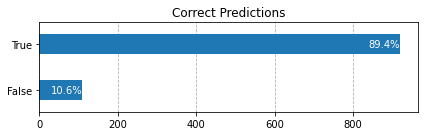

In [9]:
dp.countplot(test_df, "correct", title="Correct Predictions", annotate="percent", figsize=(6,2));

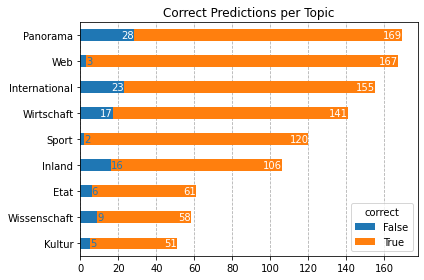

In [10]:
dp.countplot(test_df, "pred", by="correct", title="Correct Predictions per Topic", annotate="value");

### Analyse Distribution of Predictions Scores per Category

A clear separation of peaks at the lower and upper end of the range indicate that classifier is able to distinguish well between `True` and `False` for that category.

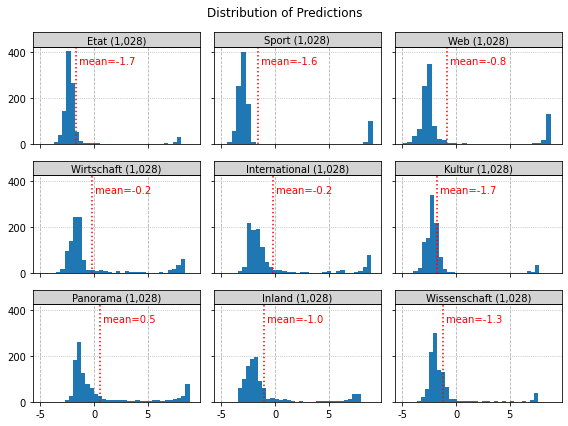

In [11]:
dp.histplot(pred_df.melt(var_name="labels"), "value", by="labels", bins=30, title="Distribution of Predictions", annotate="mean", figsize=(8,6));

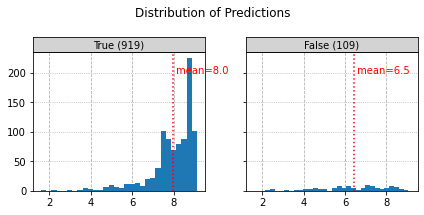

In [12]:
dp.histplot(test_df, "pred_val", by="correct", bins=30, title="Distribution of Predictions", annotate="mean", figsize=(6,3));

In [13]:
test_df[lambda x: ~x.correct].sort_values("pred_val")

,labels,text,length,pred,pred_val,correct
762,Panorama,Er ist zwar nicht mehr Griechenlands Finanzmin...,8213,Wirtschaft,2.142945,False
595,Wissenschaft,Samuel Salzborn zählt zu den umtriebigsten Rec...,3640,International,2.428035,False
873,Kultur,"Kaum kommt die Rede darauf, weicht man aus ins...",17530,Panorama,2.514864,False
292,Kultur,"""Was wir brauchen, ist kein Begrüßungskomitee ...",2101,Etat,2.596652,False
415,Panorama,Alle Religionen haben ihre hohen Feiertage – z...,84,International,3.140726,False
...,...,...,...,...,...,...
782,Inland,Kanzler fordert einheitliche EU-Standards in d...,4841,Panorama,8.604972,False
870,Wirtschaft,Außenminister fassen Beschlüsse ohne weitere D...,1133,International,8.627607,False
502,Panorama,Kreise: Reisegruppe aus der Luft und vom Boden...,2143,International,8.784657,False
243,Panorama,Der britische Premier David Cameron will beim ...,4663,International,8.844923,False


In [14]:
test_df[lambda x: ~x.correct].groupby(["labels", "pred"]).size().sort_values(ascending=False).head()

labels         pred         
Panorama       International    10
International  Panorama         10
Panorama       Inland            6
Wirtschaft     Panorama          6
Inland         Panorama          5
dtype: int64

In [15]:
test_df[lambda x: ~x.correct & (x.pred=="Panorama")]

,labels,text,length,pred,pred_val,correct
80,International,"Deutschlands Justizminister Heiko Maas: ""Wir d...",3811,Panorama,8.534176,False
227,Kultur,Italienische Tierschützer haben 8.000 Untersch...,804,Panorama,6.438666,False
234,Inland,Rechtsanwälte und Richtervereinigung lehnen Pl...,3680,Panorama,7.112714,False
240,Web,Erstmals auf öffentlichen Straßen – Ein Mensch...,2823,Panorama,5.629531,False
267,International,"Ban ""beunruhigt"" über wachsende Fremdenfeindli...",3083,Panorama,5.870708,False
282,Inland,Pilotprojekt im Betriebskindergarten des Innen...,3046,Panorama,7.579203,False
286,Wirtschaft,Zahlreiche Inseln von der Außenwelt abgeschnit...,712,Panorama,4.864848,False
302,Etat,Bereits mehrere Beschwerden beim Presserat – K...,5002,Panorama,8.348659,False
316,Wirtschaft,Holzspielzeug und Traditionsware: Der Straßbur...,1714,Panorama,5.497455,False
375,Wirtschaft,491.000 Tonnen vermeidbare Lebensmittelabfälle...,2490,Panorama,6.978320,False
